In [1]:
import networkx as nx 
import pandas as pd
import numpy as np 

import seaborn as sns
from tqdm import tqdm

from functions import *
from collections import Counter

In [2]:
import matplotlib
matplotlib.__version__

'3.4.2'

In [3]:
# data load 

# monthly index 
month_idx = pd.date_range(start='08/01/2015', end='12/01/2016', freq='MS', tz='UTC') 
month_idx_str = [m.strftime('%Y%m') for m in month_idx]

monthly_network = []

for month in tqdm(month_idx_str):
    txG = nx.read_gexf(f'/data01/storage_damini/Ethereum_network/monthly_network_{month}.gexf')

    log_value = {}
    for edge, value in nx.get_edge_attributes(txG, 'value').items():
        log_value[edge] = np.log10(value)

    nx.set_edge_attributes(txG, log_value, 'log_value')
    
    monthly_network.append(txG)

100%|██████████| 17/17 [01:29<00:00,  5.25s/it]


In [5]:
# degree, in-degree, out-degree 
txG.degree(), txG.in_degree(), txG.out_degree()

# strength, in-strength, out-strength 
txG.degree(weight='value'), txG.in_degree(weight='value'), txG.out_degree(weight='value')

(DiDegreeView({'10748': 1.608138442783206e+23, '3': 6.14033167e+18, '424193': 1.4e+17, '14': 9e+16, '637877': 1.019e+21, '24': 5.519e+21, '40432': 2.6251107996886526e+22, '151': 2.2304445625e+20, '603104': 1.7454158288000002e+20, '4920': 1.3368154899999999e+21, '317': 7.5e+17, '626074': 4.07196168e+19, '363': 1e+18, '378193': 1.716765017502873e+24, '450': 2.9196096e+20, '655372': 2.747628517351311e+21, '457': 3.38e+20, '587': 1.11096882e+18, '11379': 5.559745609618681e+24, '794': 1.7998e+20, '833': 1.511261485e+19, '534366': 6.987283507951839e+23, '960': 2.84964994e+18, '108155': 8.892093101060002e+21, '1034': 1.3581479196e+20, '649428': 5.0368903084586893e+20, '1230': 5.026940308458689e+20, '1311': 3.5313533217e+20, '1341': 1.0341097e+17, '1443': 4.3805593406e+20, '505534': 3.3e+18, '1480': 3.3e+18, '40764': 1.4821792757380008e+23, '1491': 4.001021063073655e+18, '1543': 5.7822352e+17, '1560': 2.6895914e+17, '509116': 9.95798215308303e+17, '1568': 9.95798215308303e+17, '1605': 7.001934

In [4]:
degreereg = power_law_fitting(txG.degree())
indegreereg = power_law_fitting(txG.in_degree())
outdegreereg = power_law_fitting(txG.out_degree())

NameError: name 'power_law_fitting' is not defined

### power-law fitting (log-log plot)

In [6]:
import matplotlib as mpl

colorlist = []

for i in range(3):
    color = mpl.cm.get_cmap('Set2')(i)
    color = np.array(color).reshape(1,-1)
    colorlist.append(color)

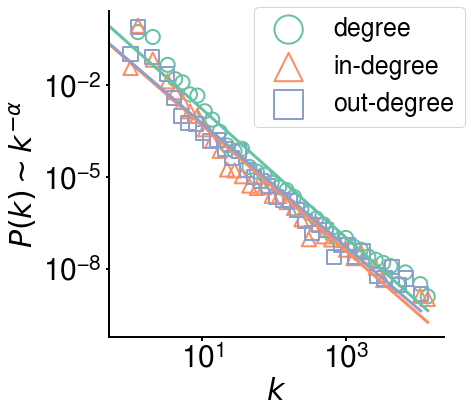

In [15]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 30
# plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
 
fig, ax = plt.subplots()

degreereg = power_law_fitting(txG.degree(), 1, ax, colorlist[0], "o", "degree")
indegreereg = power_law_fitting(txG.in_degree(), 1, ax, colorlist[1], "^", "in-degree")
outdegreereg = power_law_fitting(txG.out_degree(), 1, ax, colorlist[2], "s", 'out-degree')

plt.xlabel(r'$k$')
plt.ylabel(r'$P(k) \sim k^{-\alpha}$')
plt.legend(markerscale=2, fontsize=25, bbox_to_anchor=(1.1, 1.05))
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(2)
ax.tick_params(width=2)
plt.savefig('../figures/degree_distribution_amonth.pdf', dpi=200, bbox_inches='tight')

In [13]:
import statsmodels.api as sm

def power_law_fitting(degree_by_node, x_min=1,
                      ax=plt.subplot, color='k', marker='o', label='none',
                      visualize=True):
    frequency = [ d for node, d in degree_by_node]
    min_ = np.log10(x_min)
    max_ = np.log10(max(frequency)+1) + 1

    bins = np.logspace(min_, max_, 50)
    bins_out = np.insert(bins, 0, 0)
    bin_width = bins - bins_out[:-1]
    plot_data = Counter(np.digitize(frequency, bins))

    # logar
    plot_data = sorted(plot_data.items(), key=(lambda x: x[0]))
    x = [bins[k] for k,v in plot_data]
    y = [v/bin_width[k] for k,v in plot_data]
    y = y/sum(y)

    # fitting with stats model
    alpha = 0.01 # 99% confidence interval
    reg = sm.OLS(np.log10(y), sm.add_constant(np.log10(x))).fit()
    conf_interval = reg.conf_int(alpha)

    def power_law(x, a, b):
        return np.power(10,b)*np.power(x, a)
    
    if visualize:
        # ax.scatter(np.log10(x), np.log10(y))
        plt.scatter(x, y, edgecolors=color, marker=marker, label=label, s=200, lw=2,
                    facecolors='none', 
                    )
        draw_x = np.arange(0.5, max(x), 0.1)
        draw_y = power_law(draw_x, reg.params[1], reg.params[0])
        ax.plot(draw_x, draw_y, c=color)

        plt.xscale('log')
        plt.yscale('log')

        plt.xlim(left=0.5)
        ax.spines[['right', 'top']].set_visible(False)

    return reg, conf_interval
    # return reg.coef_[0], reg.intercept_


## Temporal Analysis (exponents)

In [15]:
power_law_exponent = {}

confidence_interval = np.array([[]])
for month, txG in tqdm(zip(month_idx_str, monthly_network)):

    degreereg = power_law_fitting(txG.degree(), 10, visualize=False)
    indegreereg = power_law_fitting(txG.in_degree(), 10, visualize=False)
    outdegreereg = power_law_fitting(txG.out_degree(), 10, visualize=False)

    # strength: weigthed by value
    # strreg = power_law_fitting(txG.degree(weight="value"), visualize=False)
    # instrreg = power_law_fitting(txG.in_degree(weight="value"), visualize=False)
    # outstrreg = power_law_fitting(txG.out_degree(weight="value"), visualize=False)
    
    # strength: weigthed by log-value
    logstrreg = power_law_fitting(txG.degree(weight="log_value"), 50, visualize=False)
    loginstrreg = power_law_fitting(txG.in_degree(weight="log_value"), 50, visualize=False)
    logoutstrreg = power_law_fitting(txG.out_degree(weight="log_value"), 50, visualize=False)

    columns = ['degree', 'indegree', 'ou']
    power_law_exponent[month] = {'degree': degreereg[0].params[1], 'in-degree': indegreereg[0].params[1], 'out-degree': outdegreereg[0].params[1],
                                #  'strength': strreg.coef_[0], 'in-strength': instrreg.coef_[0], 'out-strength': outstrreg.coef_[0],
                                 'strength': logstrreg[0].params[1], 'in-strength': loginstrreg[0].params[1], 'out-strength': logoutstrreg[0].params[1]
                                 }

    conf_mat = np.concatenate((degreereg[1][1], indegreereg[1][1], outdegreereg[1][1], logstrreg[1][1], loginstrreg[1][1], logoutstrreg[1][1]))

    # confidence_interval = np.vstack([confidence_interval, conf_mat])
    if month == '201508':
        confidence_interval = conf_mat
    else:    
        confidence_interval = np.vstack([confidence_interval, conf_mat])


17it [00:10,  1.66it/s]


In [58]:
confidence_interval.T

array([[-1.90616331, -1.87921719, -1.92728536, -1.80427671, -1.78626482,
        -1.78107456, -1.98299937, -1.96479481, -1.90340327, -1.85789818,
        -1.95128726, -2.00842785, -1.90173938, -1.88121401, -1.86917333,
        -1.95440131, -2.07457669],
       [-1.22224444, -1.24693894, -1.31357647, -1.1241451 , -1.12055377,
        -1.28291816, -1.4437593 , -1.53261729, -1.50184813, -1.47864744,
        -1.60747663, -1.71225354, -1.54677815, -1.54287386, -1.52174967,
        -1.61415359, -1.78151022],
       [-1.99717109, -2.14766011, -2.0778207 , -2.13277773, -2.12047819,
        -1.87064123, -1.92772581, -1.93176439, -1.93371316, -1.80963679,
        -1.92539015, -2.00187951, -1.8939149 , -1.86996844, -1.87925561,
        -1.87978443, -2.05606693],
       [-0.92569306, -0.97496015, -0.94710031, -0.86360143, -0.86473118,
        -0.88533353, -1.08274132, -1.22233486, -1.32547912, -1.27400089,
        -1.37675107, -1.54026878, -1.42185747, -1.37308821, -1.4099074 ,
        -1.44567439

In [65]:
degreereg[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     715.0
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           2.05e-24
Time:                        12:34:10   Log-Likelihood:                -15.835
No. Observations:                  36   AIC:                             35.67
Df Residuals:                      34   BIC:                             38.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1784      0.190      0.941      0.353      -0.207       0.564
x1            -1.9280      0.072    -26.740      0.000      -2.075      -1.782
==============================================================================
Omnibus:                       43.245   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.218
Skew:                           2.657   Prob(JB):                     6.03e-41
Kurtosis:                      12.760   Cond. No.                         8.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
import matplotlib as mpl

colorlist = []

for i in [9,7,6]:
    color = mpl.cm.get_cmap('GnBu', 10)(i)
    color = np.array(color).reshape(1,-1)
    colorlist.append(color)

for i in [9,7,6]:
    color = mpl.cm.get_cmap('OrRd', 10)(i)
    color = np.array(color).reshape(1,-1)
    colorlist.append(color)


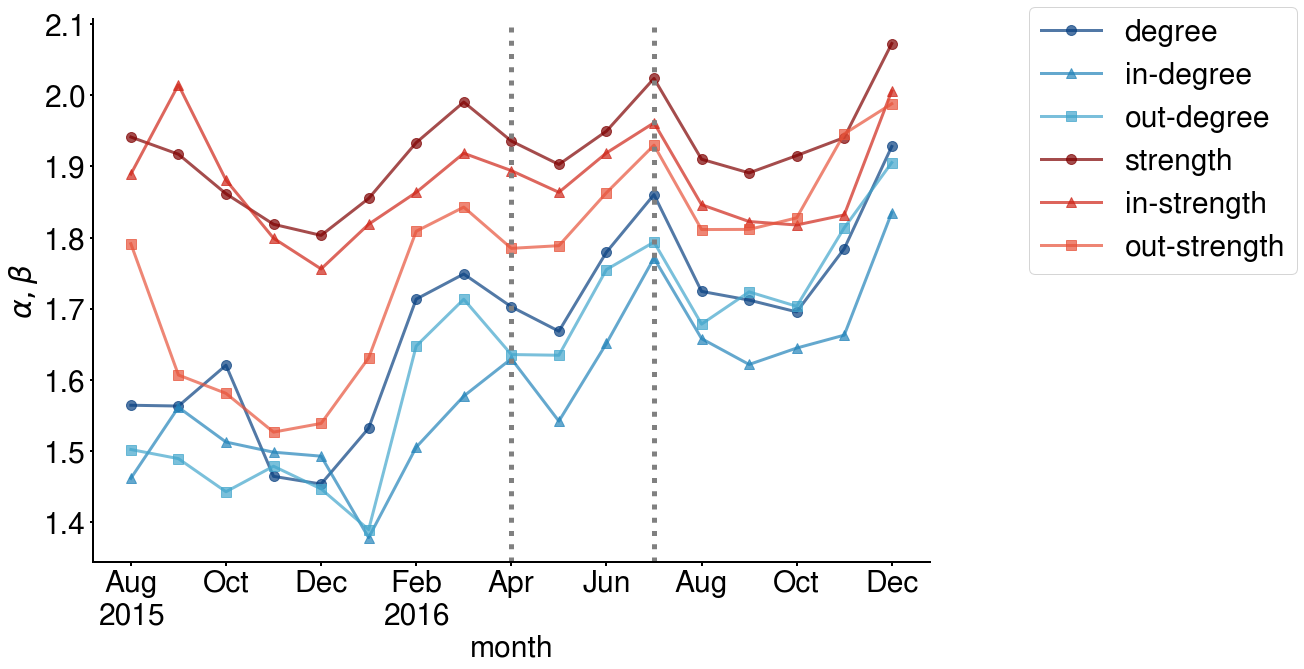

In [19]:
plt.rcParams['figure.figsize'] = (15,10)

df =  pd.DataFrame.from_dict(power_law_exponent, orient='index')
df = df.reset_index().rename(columns={'index':'month'})

fig, ax = plt.subplots()

cols = df.columns
errors = confidence_interval.T
markers = ['o', '^', 's', 'o', '^', 's']

for i in range(1, 7):
        ax.plot(df['month'], -df[cols[i]], marker=markers[i-1], label=cols[i],
                c=colorlist[i-1], alpha=.7,
                )
        # ax.fill_between(df['month'], -errors[2*i-1], -errors[2*i-2], alpha=.3,
        #         )
# meltdf = df.melt(id_vars='month', value_vars=df.columns[1:4])
# sns.lineplot(data=meltdf, x='month', y='value', hue='variable', 
#         #      style='variable', 
#              markers=['o', '^', 'x'], dashes=False,
#              ax=ax)

showmonth = np.array(month_idx)[[0,2,4,6,8,10,12,14,16]]
xticks = np.array(month_idx_str)[[0,2,4,6,8,10,12,14,16]]
ax.axvline(x='201604', color='gray', linestyle=':', linewidth=5)
ax.axvline(x='201607', color='gray', linestyle=':', linewidth=5)

plt.xticks(xticks, 
        [ts.strftime('%b\n%Y') if ts.year != showmonth[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(showmonth)])


plt.ylabel(r'$\alpha, \beta$')
plt.xlabel('month')
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(2)
ax.tick_params(width=2)
plt.savefig('../figures/degree_distribution.pdf', dpi=200, bbox_inches='tight')

In [114]:
size = []

for month, txG in tqdm(zip(month_idx_str, monthly_network)):
    size.append(len(txG.nodes())) 

17it [00:00, 22904.97it/s]


In [178]:
[ts.strftime('%b\n%Y') if ts.year != showdate[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(showdate)]

['Aug\n2015', 'Oct', 'Dec', 'Feb\n2016', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']

In [ ]:
plt.rcParams["font.family"]="Arial"
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, figsize=(12,9))

def draw_time_series(data, ax, scale='linear'):
    date_idx = pd.date_range(start='08/01/2015', end='12/31/2016', freq='1MS') 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.plot(date_idx, data, marker="o", markersize=10, markeredgewidth=2, linewidth=2, color="b", label='sklearn')

    # target_exponents_stats = [ exponent_list[0][0] for exponent_list in power_law_exponent]
    # ax.plot(date_idx, target_exponents_stats, marker="o", markersize=10, markeredgewidth=2, linewidth=2, color="g", label='statsmodels')
    # ax.tick_params(axis='x', labelrotation=20)
    ax.set_xlabel("Month")
    ax.set_ylabel(r"$\gamma$   $[k^{-\gamma}]$")
    ax.axvline(x=datetime(2016, 4, 1), color='r', linestyle=':', linewidth=5, alpha=0.9)
    ax.text(datetime(2016, 4, 7),2.02, "2016.04\nThe DAO \ncreated", fontsize=22, fontweight='bold')
    ax.axvline(x=datetime(2016, 7, 1), color='r', linestyle=':', linewidth=5)
    ax.text(datetime(2016, 7,7),1.79, "2016.07\nHardFork", fontsize=25, fontweight='bold')

    showdate = date_idx[[0,2,4,6,8,10,12,14,16]]
    plt.xticks(showdate, 
            [ts.strftime('%b\n%Y') if ts.year != showdate[idx-1].year
                        else ts.strftime('%b') for idx, ts in enumerate(showdate)])
    
    if scale == 'log':
        plt.yscale('log')
    # plt.show()
    # plt.legend()

# evolving network
nnodes, nedges = [], []
density = []

for network in monthly_network:

    nnodes.append(network.number_of_nodes())
    nedges.append(network.number_of_edges())

    density.append(nx.density(network))
    
draw_time_series(nnodes, ax)
draw_time_series(nedges, ax)
plt.yscale('log')
# draw_time_series(density, scale='log')

### Statistics

# number of nodes 
# number of edges 
# number of miner, genesis who trade in the month 
# number of exchanges

In [83]:
# number of nodes 
# number of edges 
# number of miner, genesis who trade in the month 
# number of exchanges

network_info = []
for month, txG in zip(month_idx_str, monthly_network):

    nodes, edges, density = len(txG.nodes()), len(txG.edges()), nx.density(txG)
    miner, genesis, exchange = len(nx.get_node_attributes(txG, 'miner')), len(nx.get_node_attributes(txG, 'genesis')), len(nx.get_node_attributes(txG, 'Exchange'))

    network_info.append([month, nodes, edges, density, miner, genesis, exchange])

    print(month, '&', nodes, '&', edges, '&', density, '&', miner, '&', genesis, '&', exchange)


201508 & 10575 & 16468 & 0.00014727233622235011 & 1180 & 1520 & 6
201509 & 6337 & 11267 & 0.00028061405438318805 & 775 & 407 & 6
201510 & 7454 & 11407 & 0.00020532930251650168 & 562 & 327 & 6
201511 & 8518 & 12439 & 0.00017145935467710767 & 485 & 238 & 6
201512 & 7300 & 12592 & 0.00023632436043969244 & 431 & 242 & 6
201601 & 18678 & 28650 & 8.212722268728493e-05 & 526 & 586 & 6
201602 & 37332 & 55807 & 4.004403165862329e-05 & 677 & 1063 & 9


201603 & 71052 & 113661 & 2.251463811597651e-05 & 817 & 1447 & 10
201604 & 55021 & 96961 & 3.2029342274660127e-05 & 730 & 690 & 14
201605 & 118848 & 201441 & 1.4261584106188415e-05 & 865 & 1674 & 17
201606 & 114283 & 178587 & 1.3673836330239084e-05 & 729 & 958 & 15
201607 & 135162 & 232132 & 1.2706589725199422e-05 & 807 & 1121 & 25
201608 & 112487 & 183750 & 1.4522003590550254e-05 & 616 & 891 & 28
201609 & 106389 & 174238 & 1.5394071734228416e-05 & 494 & 456 & 25
201610 & 120429 & 194116 & 1.3384519338394083e-05 & 486 & 374 & 30
201611 & 142375 & 224587 & 1.1079500722188712e-05 & 401 & 345 & 27
201612 & 111571 & 197376 & 1.5856071103257798e-05 & 331 & 311 & 31


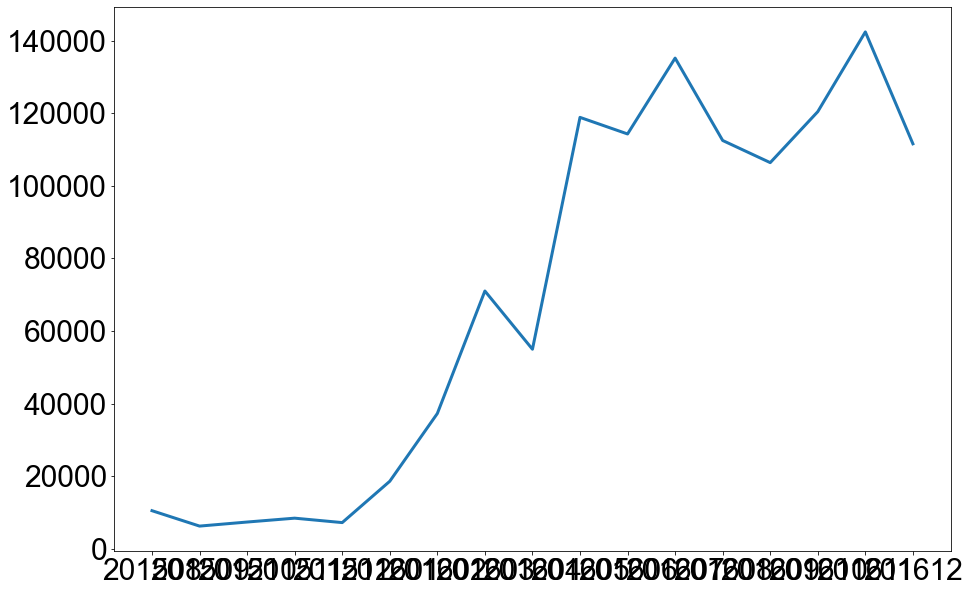

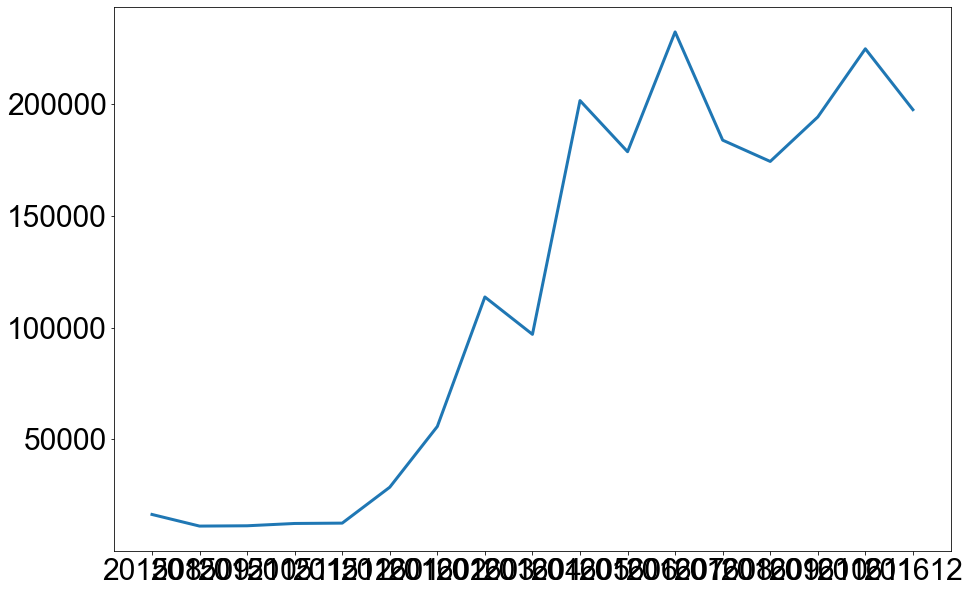

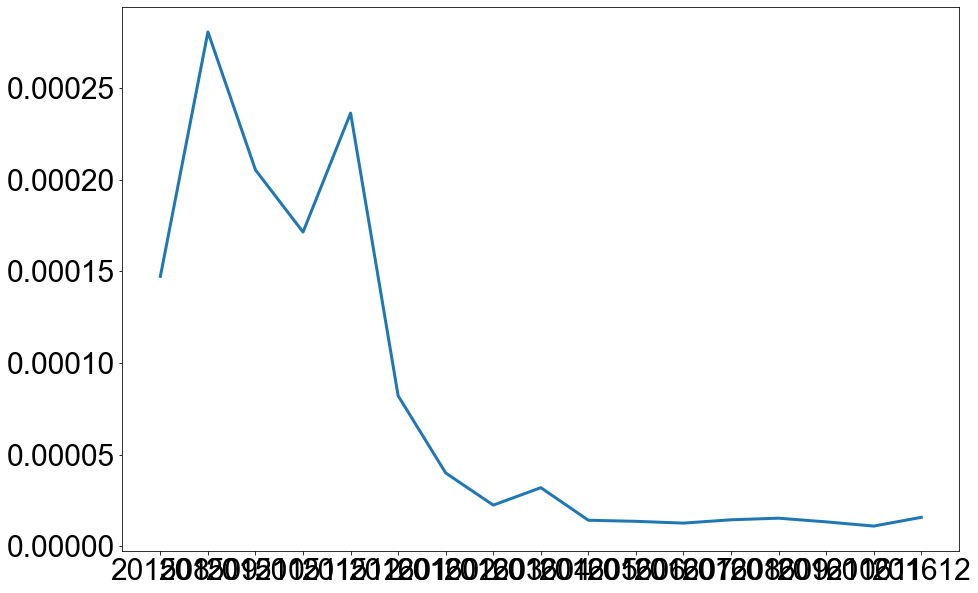

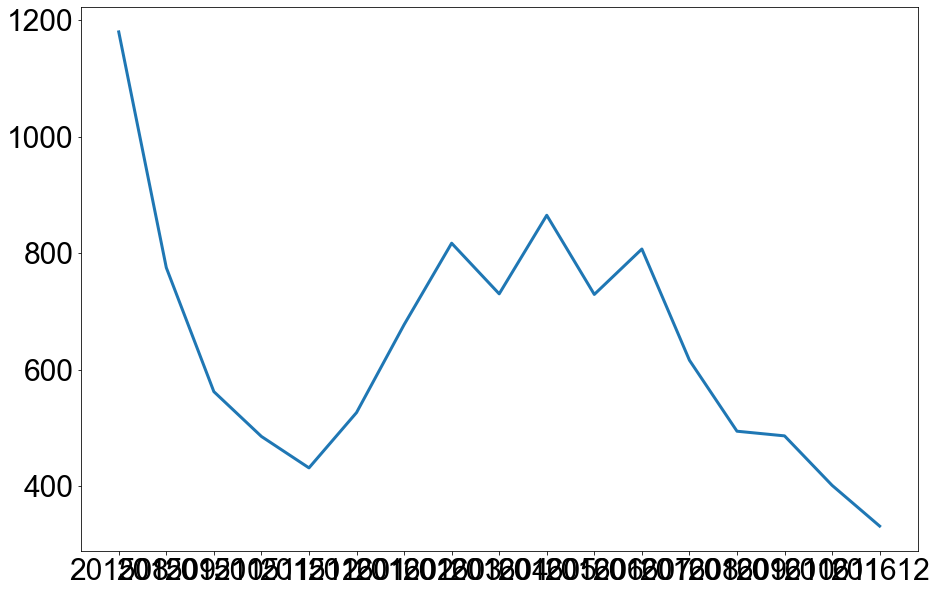

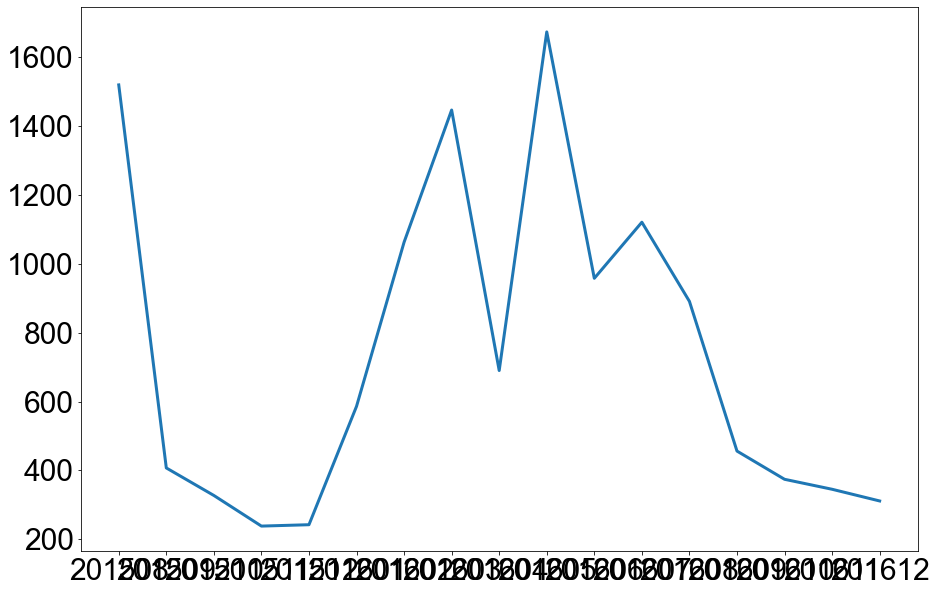

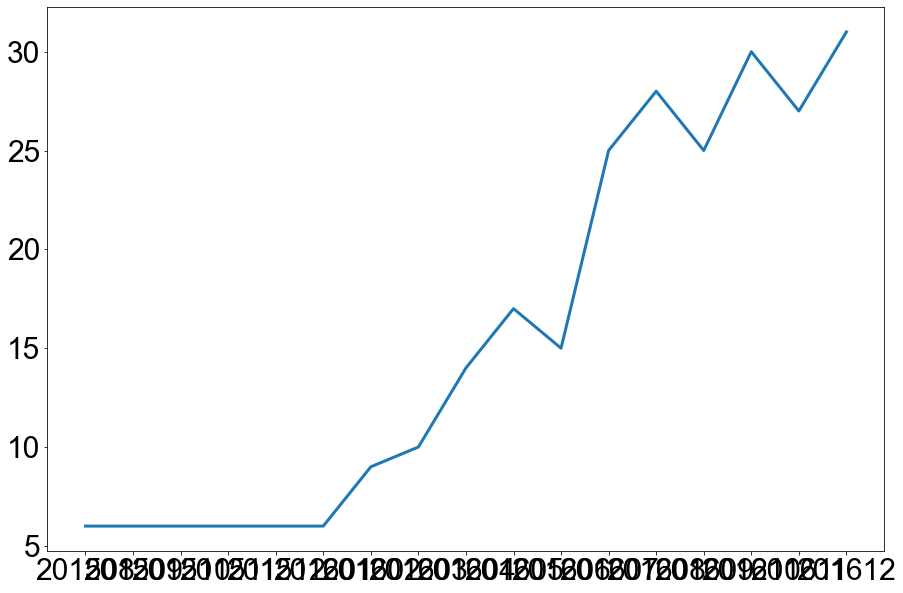

In [94]:
df = pd.DataFrame(np.array(network_info))

for i in df.columns[1:]:
    plt.plot(df[0], df[i].astype('float'))
    plt.show()